
# Inertia as a Form of Model Compression in Convolutional Neural Networks


> *In submission for Deep Learning Project, Spring 2025*

**Labiba Shahab**

**Ahmed Wali**

## In a Gist:

Standard dxd convolution layers involve d^2 learnable parameters and d^2 computations per convolution operation. In this project, we propose an inertial convolution mechanism that dynamically decides whether a detailed convolution is necessary. The goal is to reduce both computations and learnable parameters while maintaining performance on vision tasks like MNIST classification.

Instead of learning a full dxd kernel, we use a (d-k)x(d-k) core filter to convolve a central patch. The surrounding d^2-(d-k)^2 pixels act as an inertial periphery—evaluating local divergence or “friction.” If the divergence is high, we re-apply the core filter across the full dxd region in another convolution and stack the outputs. If low, we skip detailed computation.

In the best case, we perform just d-k computation with d-k learnable parameters.
In the worst case, we perform up to d computations, but still only learn d-k parameters, hence effectively pruning the model with estimation compression.



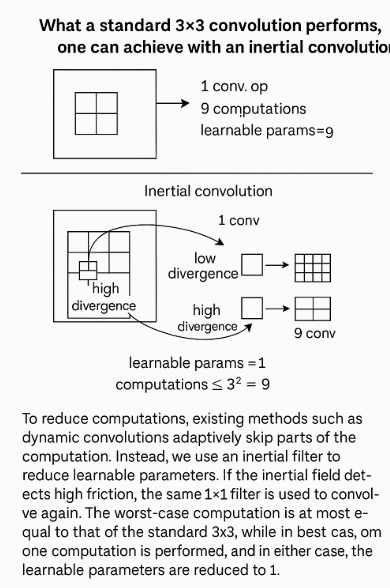


> *What you usually achieve with a standard convolution, you can accomplish efficiently using a smaller convolution + peripheral inertia mechanism (inertial filter)*
~ Group 39


## Abstract

Insspired by the pulsating thrust pattern of rockets, our project introduces a novel approach for CNN model compression termed "Inertial Convolution." Unlike traditional pruning methods, Inertial Convolution leverages the concept of computational inertia to dynamically reduce redundant calculations within convolutional layers.

In standard CNN operations, filters of fixed sizes (e.g., 3x3) consistently scan across the input image. However, Inertial Convolution proposes a core smaller filter (e.g., 2x2) complemented by peripheral kxk "inertia" pixels. These peripheral pixels assess whether additional computation is necessary based on the divergence from the primary filter region.

If the surrounding inertia pixels detect minimal variance—representing "low friction" or minimal computational resistance—the convolution operation dynamically skips processing these pixels. This mechanism mirrors the pulse-like movement observed in certain rocket propulsion methods, optimizing computational resources by selectively bypassing redundant operations.

In summary, Inertial Convolution aims to achieve computational efficiency by intelligently minimizing unnecessary convolutional computations, making CNN deployment feasible on resource-constrained environments such as free-tier GPU platforms.

## Background

There has been extensive research in reducing neural network complexity:

Dynamic convolutions and skip-convolutions conditionally skip expensive operations. This project is inspired from [Dynamic Sparse Convolutions](https://arxiv.org/pdf/2102.04906), [Skip Convolutions](https://openaccess.thecvf.com/content/CVPR2021/papers/Habibian_Skip-Convolutions_for_Efficient_Video_Processing_CVPR_2021_paper.pdf), and [Fractional Skipping](https://arxiv.org/abs/2001.00705)

Pruning, quantization, and knowledge distillation reduce parameters, memory, or model depth.

Our approach is inspired by these ideas but focuses on parameter reuse and friction-aware skipping, offering a novel trade-off between learning capacity and computational efficiency.

## Novelty

Inspired from computational optimization, our project proposes a similar mechanism to do model compression by estimation.

## What we aim to do?

We would want to train standard CNNs with datasets as mentioned below, and compare the computational cost and efficiency of these models with the ones we would tune to use inertial filters.

#Data Selection & Annotation

##Setup & Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10

##Defining Utility Functions

In [ ]:
def imshow(img, label=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if label is not None:
        plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

def get_data_details(dataset):
    print(f"Number of classes: {len(dataset.classes)}")
    print(f"Classes: {dataset.classes}")
    print(f"Dataset size: {len(dataset)}")

##Loading Dataset

###MNIST Dataset
MNIST consists of 70,000 grayscale images (28x28 pixels) of handwritten digits.
- **Model**: LeNet-5 / Simple CNN
- **Expected Accuracy**: 99%+
- **Link**: [PyTorch MNIST Example](https://github.com/pytorch/examples/tree/main/mnist)

This dataset serves as a good starting point due to its simplicity and low variance. We will use this dataset as the initial starting point for our analysis. We will adapt the standard pytorch LeNet-5 implementation with 2 convolutional layers in 3x3 filters. We will then train a similar model with the only alteration made such that the two convolutional layers use 1x1 core filters + 1 pixel periphery, and we would compare the results. If the results are comparable, we would have effectively reduced the number of learnable parameters and potentially the computational bulk due to the smaller kernel size.

**What do we expect?**

Since the MNIST dataset is a grascale dataset, we anticipate low divergence or friction across patches in images, hence we anticipate improved performance due to the use of inertial filters.

In [2]:
def print_dataset_metrics(trainset, testset):
    print("MNIST Dataset Stats:")
    print(f"Training Samples : {len(trainset)}")
    print(f"Testing Samples  : {len(testset)}")
    print(f"Image Size       : {trainset[0][0].shape}")  # (1, 28, 28)
    print(f"Channels         : {trainset[0][0].shape[0]} (Grayscale)")

MNIST Dataset Stats:
Training Samples : 60000
Testing Samples  : 10000
Image Size       : torch.Size([1, 28, 28])
Channels         : 1 (Grayscale)


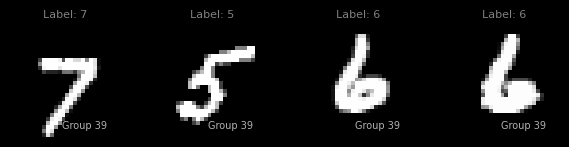

In [9]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.datasets import MNIST

# Data
transform = transforms.ToTensor()
train_mnist = MNIST(root='./data', train=True, download=True, transform=transform)
test_mnist = MNIST(root='./data', train=False, download=True, transform=transform)
print_dataset_metrics(train_mnist, test_mnist)

# DataLoader
trainloader_mnist = torch.utils.data.DataLoader(train_mnist, batch_size=4, shuffle=True)
dataiter = iter(trainloader_mnist)
images, labels = next(dataiter)

# Fancy Grid
fig, axs = plt.subplots(1, 4, figsize=(6, 1.5), facecolor='black')

for i in range(4):
    axs[i].imshow(images[i][0], cmap='gray')
    axs[i].set_title(f"Label: {labels[i].item()}", color='grey', fontsize=8)
    axs[i].axis('off')
    axs[i].text(
        24, 26, 'Group 39',
        color='white',
        fontsize=7,
        ha='right',
        va='bottom',
        alpha=0.7
    )

plt.tight_layout()
plt.show()

Now we calculate the divergence across the dataset's image patches. Pixel values in MNIST after ToTensor() range from 0.0 (black) to 1.0 (white), and we expect a low divergence across patches.

> A divergence score of ~0.1 means the average patch only slightly deviates from the overall structure — which makes sense for MNIST digits with a lot of black background and sparse white strokes.

In [12]:
import torch
import torch.nn.functional as F

def patch_divergence(image_tensor, patch_size=7):
    """
    image_tensor: 1x28x28 (grayscale MNIST)
    Returns a scalar divergence score.
    """
    _, H, W = image_tensor.shape
    patches = image_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.contiguous().view(-1, patch_size, patch_size)
    patches_flat = patches.view(patches.size(0), -1)
    mean_patch = patches_flat.mean(dim=0, keepdim=True)
    mse = F.mse_loss(patches_flat, mean_patch.expand_as(patches_flat), reduction='none')
    divergence_score = mse.mean().item()
    return divergence_score

In [14]:
for i in range(4):
    score = patch_divergence(images[i])
    print(f"🧩 Image {i} Patch Divergence Score: {score:.8f}")

🧩 Image 0 Patch Divergence Score: 0.09210595
🧩 Image 1 Patch Divergence Score: 0.10378123
🧩 Image 2 Patch Divergence Score: 0.12827823
🧩 Image 3 Patch Divergence Score: 0.13672121


We will then follow up with experimentation in more datasets:

## Fashion-MNIST Dataset
Fashion-MNIST is a drop-in replacement for MNIST but contains Zalando's article images.
- **Existing SOA Model**: Simple CNN / ResNet-based
- **Expected Accuracy**: ~93-95%
- **Link**: [Fashion-MNIST GitHub](https://github.com/zalandoresearch/fashion-mnist)

This gives a little more divergence, hence giving us with a more naunced understanding of the application of the inertial filters.

FashionMNIST Dataset Stats:
Training Samples : 60000
Testing Samples  : 10000
Image Size       : torch.Size([1, 28, 28])
Channels         : 1 (Grayscale)



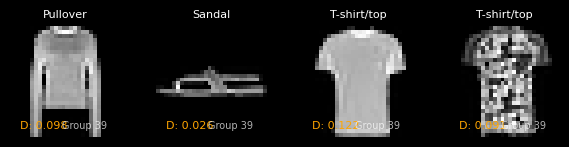

Image 0 - Label: Pullover | Divergence Score: 0.098366
Image 1 - Label: Sandal | Divergence Score: 0.026107
Image 2 - Label: T-shirt/top | Divergence Score: 0.122434
Image 3 - Label: T-shirt/top | Divergence Score: 0.091187


In [23]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import FashionMNIST
import torch.nn.functional as F

# Label map for FashionMNIST
fashion_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Load dataset
transform = transforms.ToTensor()
fashion_train = FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_test = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Print metrics
def print_dataset_metrics(trainset, testset):
    print("FashionMNIST Dataset Stats:")
    print(f"Training Samples : {len(trainset)}")
    print(f"Testing Samples  : {len(testset)}")
    print(f"Image Size       : {trainset[0][0].shape}")
    print(f"Channels         : {trainset[0][0].shape[0]} (Grayscale)\n")

print_dataset_metrics(fashion_train, fashion_test)

# Patch divergence function
def patch_divergence(image_tensor, patch_size=7):
    _, H, W = image_tensor.shape
    patches = image_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.contiguous().view(-1, patch_size, patch_size)
    patches_flat = patches.view(patches.size(0), -1)
    mean_patch = patches_flat.mean(dim=0, keepdim=True)
    mse = F.mse_loss(patches_flat, mean_patch.expand_as(patches_flat), reduction='none')
    return mse.mean().item()

# Load images
trainloader_fashion = torch.utils.data.DataLoader(fashion_train, batch_size=4, shuffle=True)
dataiter_fashion = iter(trainloader_fashion)
images_f, labels_f = next(dataiter_fashion)

# Display
fig, axs = plt.subplots(1, 4, figsize=(6, 1.5), facecolor='black')
divergence_scores = []

for i in range(4):
    axs[i].imshow(images_f[i][0], cmap='gray')
    class_label = fashion_labels[labels_f[i].item()]
    score = patch_divergence(images_f[i])
    divergence_scores.append(score)

    axs[i].set_title(f"{class_label}", color='white', fontsize=8)
    axs[i].axis('off')
    axs[i].text(2, 26, f"D: {score:.3f}", color='orange', fontsize=8, ha='left', va='bottom')
    axs[i].text(24, 26, 'Group 39', color='white', fontsize=7, ha='right', va='bottom', alpha=0.7)

plt.tight_layout()
plt.show()

# Print divergence text
for i in range(4):
    print(f"Image {i} - Label: {fashion_labels[labels_f[i]]} | Divergence Score: {divergence_scores[i]:.6f}")


## CIFAR-10 Dataset
CIFAR-10 consists of 60,000 32x32 color images in 10 classes.
- **Model**: ResNet18 / VGG-like models
- **Expected Accuracy**: ~92–96%
- **Link**: [CIFAR-10 GitHub](https://github.com/kuangliu/pytorch-cifar)

> This repository explores multiple state of the art models including VGG, ResNet18, and many others providing us with a good point to start comparing the results of our implementation with further models.


CIFAR-10 Dataset Stats:
Training Samples : 50000
Testing Samples  : 10000
Image Size       : torch.Size([3, 32, 32])
Channels         : 3 (RGB)



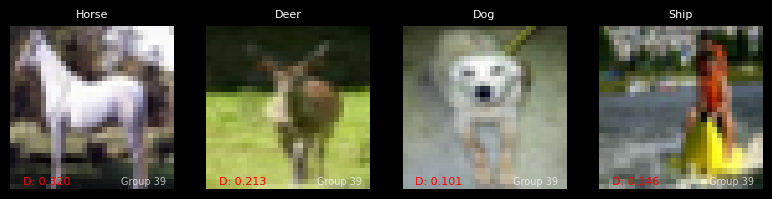

Image 0 - Label: Horse | Divergence Score: 0.320002
Image 1 - Label: Deer | Divergence Score: 0.213070
Image 2 - Label: Dog | Divergence Score: 0.100875
Image 3 - Label: Ship | Divergence Score: 0.145847


In [27]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torch.nn.functional as F

# CIFAR-10 label names
cifar_labels = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Load CIFAR-10
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_train = CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
cifar_test = CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)

# Dataset stats
def print_dataset_metrics(trainset, testset):
    print("CIFAR-10 Dataset Stats:")
    print(f"Training Samples : {len(trainset)}")
    print(f"Testing Samples  : {len(testset)}")
    print(f"Image Size       : {trainset[0][0].shape}")
    print(f"Channels         : {trainset[0][0].shape[0]} (RGB)\n")

print_dataset_metrics(cifar_train, cifar_test)

# Patch divergence for RGB
def patch_divergence(image_tensor, patch_size=8):
    C, H, W = image_tensor.shape
    patches = image_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.contiguous().view(C, -1, patch_size, patch_size)
    patches_flat = patches.view(C, patches.shape[1], -1)
    mean_patch = patches_flat.mean(dim=1, keepdim=True)
    mse = F.mse_loss(patches_flat, mean_patch.expand_as(patches_flat), reduction='none')
    return mse.mean().item()

# Load samples
trainloader_cifar = torch.utils.data.DataLoader(cifar_train, batch_size=4, shuffle=True)
dataiter_cifar = iter(trainloader_cifar)
images_c, labels_c = next(dataiter_cifar)

# Unnormalize for display
def unnormalize(img):
    return img * 0.5 + 0.5

# Display & calc
fig, axs = plt.subplots(1, 4, figsize=(8, 2), facecolor='black')
divergence_scores = []

for i in range(4):
    img = unnormalize(images_c[i])
    axs[i].imshow(img.permute(1, 2, 0).clamp(0, 1))  # CxHxW to HxWxC
    label_text = cifar_labels[labels_c[i].item()]
    score = patch_divergence(images_c[i])
    divergence_scores.append(score)

    axs[i].set_title(f"{label_text}", color='white', fontsize=8)
    axs[i].axis('off')
    axs[i].text(2, 31, f"D: {score:.3f}", color='red', fontsize=8, ha='left', va='bottom')
    axs[i].text(30, 31, 'Group 39', color='white', fontsize=7, ha='right', va='bottom', alpha=0.7)

plt.tight_layout()
plt.show()

# Text output
for i in range(4):
    print(f"Image {i} - Label: {cifar_labels[labels_c[i]]} | Divergence Score: {divergence_scores[i]:.6f}")


## Future Preposition

> *if time and resources are available*

We may go into exploring CIFAR-100 (ResNet34/50, DenseNet, 75–85%, https://github.com/weiaicunzai/pytorch-cifar100) and Tiny ImageNet (ResNet18/34, ~60-65%, https://github.com/rmccorm4/Tiny-Imagenet-200 [extra*]) if the time and resources permit for further analysis.


## Conclusion

We will try to estimate the standard convolutions using smaller kernels with an inertial mechanism effectively reducing the learnable parameters, hence weights, acting as model compression.